In [1]:
!pip install wfdb
!pip install neurokit2


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\Hemath Gaddey\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


  Obtaining dependency information for neurokit2 from https://files.pythonhosted.org/packages/b4/22/e7e3b341b80a1e56f270a0137d4a3e6b20a58ae56c77785c0f6d3c6ba653/neurokit2-0.2.7-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.3 MB 2.6 MB/s eta 0:00:01
   ------ --------------------------------- 0.2/1.3 MB 2.4 MB/s eta 0:00:01
   ------ --------------------------------- 0.2/1.3 MB 2.4 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.3 MB 2.0 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.3 MB 2.0 MB/s eta 0:00:01
   -------- ------------------------------- 0.3/1.3 MB 1.1 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.3 MB 1.2 MB/s eta 0:00:01
   ------------ --------------------------- 0.4/1.3 MB 1.2 MB/s eta 0:00:01
   ------------ --------------------------- 0.4

ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\Hemath Gaddey\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [1]:
import wfdb
import pandas as pd
import neurokit2 as nk
from wfdb import processing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import os

directory = './mit-bih-atrial-fibrillation-database-1.0.0/files/'
files = os.listdir(directory)

# Extract only file names without extensions and get unique names
unique_file_names_without_extension = set(os.path.splitext(file)[0] for file in files)

# Convert the set back to a list if necessary
unique_file_names_list = list(unique_file_names_without_extension)
unique_file_names_list.remove('old')
unique_file_names_list.remove('RECORDS')
unique_file_names_list.remove('notes')
unique_file_names_list.remove('SHA256SUMS')
unique_file_names_list.remove('ANNOTATORS')
unique_file_names_list.remove('00735')
unique_file_names_list.remove('03665')
unique_file_names_list.remove('07162') #IDK - ghc
unique_file_names_list.remove('07859') #IDK - ghc
# unique_file_names_list.remove('08378')
print(len(unique_file_names_list))
print(unique_file_names_list)

21
['05091', '06995', '04908', '05121', '04048', '08378', '08455', '04043', '08405', '08434', '04015', '04126', '07879', '05261', '06453', '08215', '08219', '07910', '04936', '04746', '06426']


In [3]:
# Initialize pdDataset
#df1 = pd.read_csv(f'./e/CUSTOM_atrial_fibrillation_dataset_{unique_file_names_list[1]}.csv')
df1 = pd.read_csv(f'./g/0-2.csv')
len(df1)

53365

<AxesSubplot: xlabel='Class', ylabel='count'>

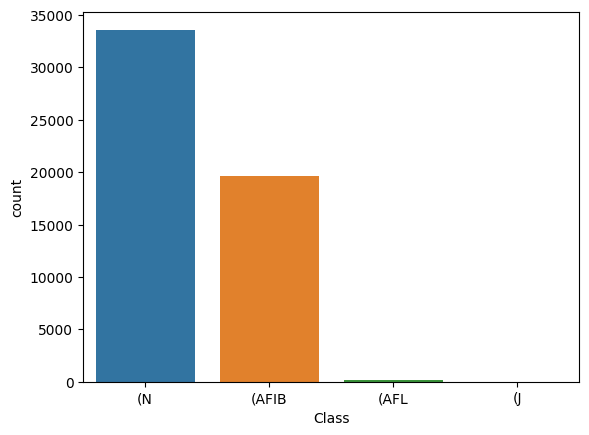

In [6]:
import seaborn as sns
sns.countplot(df1,x='Class')


In [6]:
df = df1.drop(['Class'],axis=1)
# Replace NaN values with 0
df.fillna(0, inplace=True)

# Resample each row to 1011 columns
new_df = pd.DataFrame()
for index, row in df.iterrows():
    resampled_row = pd.Series(row).interpolate(method='linear', limit_direction='both').values
    resampled_row = np.interp(np.linspace(0, len(resampled_row) - 1, 1011), range(len(resampled_row)), resampled_row)
    new_df = new_df.append(pd.Series(resampled_row), ignore_index=True)

# You can then save the new DataFrame to a new CSV file if needed
new_df.to_csv('resampled_dataset.csv', index=False)

C:\Users\Hemath Gaddey\AppData\Local\Temp\ipykernel_15660\2574093722.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(pd.Series(resampled_row), ignore_index=True)


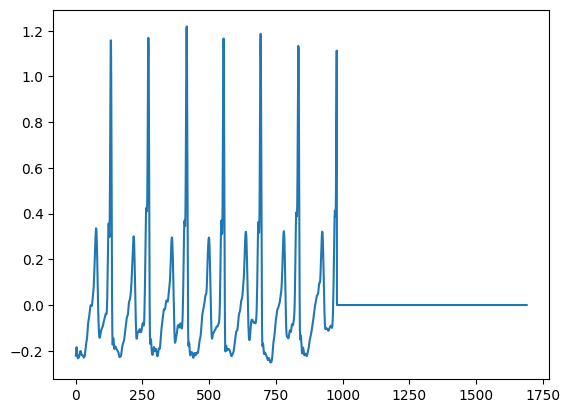

In [30]:
df = df1.drop(['Class'],axis=1)
df.fillna(0, inplace=True)
# Keep columns up to 600 only
df = df.iloc[:, :1700]
plt.plot(np.array(df.iloc[5210][9:]))

In [19]:
X = df
Y = df1['Class']

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 4, kernel_size=701, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.conv2 = nn.Conv1d(4, 8, kernel_size=9, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.conv3 = nn.Conv1d(8, 12, kernel_size=3, stride=1)
        self.pool3 = nn.MaxPool1d(kernel_size=5, stride=5)
        self.fc = nn.Linear(7 * 12, 2)  # Calculate the input size based on the output size of last pooling layer

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, 7 * 12)  # Reshape for fully connected layer
        x = self.fc(x)
        return x

# Example usage
import pandas as pd
import numpy as np

# Generate random data with 1700 columns
data = np.random.rand(1, 1700)

# Reshape data to add a channel dimension
data = np.expand_dims(data, axis=0)
data = torch.tensor(data, dtype=torch.float32).cuda()

# Instantiate the model
model = CNN().to(torch.device('cuda'))
# Forward pass
output = model(data)
print(output.shape)  # This should print torch.Size([1, 2]) indicating batch size 1 and 2 output classes

torch.Size([1, 2])


In [21]:
classes = list(Y.unique())
Y = []
for i in df1['Class']:
    Y.append(classes.index('(N'))
X = df

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [23]:
np.shape(X_train.values)

(42692, 1700)

In [24]:
# Define your dataset and dataloader (assuming you have them prepared)
# For simplicity, let's assume you have X_train, y_train, X_val, y_val

# Define your dataset and dataloader (assuming you have them prepared)
# For simplicity, let's assume you have X_train, y_train, X_val, y_val

# Assuming X_train, X_val are pandas DataFrames

# Convert pandas DataFrames to numpy arrays
X_train_np = X_train.values
X_val_np = X_val.values

# Reshape data to add a channel dimension
X_train_np = np.expand_dims(X_train_np, axis=1)
X_val_np = np.expand_dims(X_val_np, axis=1)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train, dtype=torch.long).cuda()
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32).cuda()
y_val_tensor = torch.tensor(y_val, dtype=torch.long).cuda()

# Assuming you have defined your CNN model as 'model'
model = CNN().cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 64

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(X_train_tensor)}')

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_val_tensor)
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == y_val_tensor).sum().item()
    total = y_val_tensor.size(0)
    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Epoch [1/10], Loss: 2.9285727204559297e-05
Epoch [2/10], Loss: 1.4587633094690877e-08
Epoch [3/10], Loss: 4.862730982264884e-09
Epoch [4/10], Loss: 2.1482245420368258e-09
Epoch [5/10], Loss: 1.0941341137158898e-09
Epoch [6/10], Loss: 6.082534300530327e-10
Epoch [7/10], Loss: 3.5667363196625677e-10
Epoch [8/10], Loss: 2.17156701001118e-10
Epoch [9/10], Loss: 1.3554509794723075e-10
Epoch [10/10], Loss: 8.629462553613213e-11
Validation Accuracy: 100.00%


In [145]:
file_names = []
for csv_file_name in os.listdir('./e/'):
    file_names.append(csv_file_name)
    
for i in range(0,len(file_names),5):
    print(f"i - {i}")
    big_file = pd.DataFrame()
    for file_name in file_names[i:i+5]:
        print("\t"+file_name)
        file = pd.read_csv('./e/'+file_name)
        big_file = pd.concat([big_file, file], ignore_index=True)
    big_file.to_csv(f"{i}-{i+5}.csv")

i - 0
	CUSTOM_atrial_fibrillation_dataset_04015.csv
	CUSTOM_atrial_fibrillation_dataset_04043.csv
	CUSTOM_atrial_fibrillation_dataset_04048.csv
	CUSTOM_atrial_fibrillation_dataset_04126.csv
	CUSTOM_atrial_fibrillation_dataset_04746.csv
i - 5
	CUSTOM_atrial_fibrillation_dataset_04908.csv
	CUSTOM_atrial_fibrillation_dataset_04936.csv
	CUSTOM_atrial_fibrillation_dataset_05091.csv
	CUSTOM_atrial_fibrillation_dataset_05121.csv
	CUSTOM_atrial_fibrillation_dataset_05261.csv
i - 10
	CUSTOM_atrial_fibrillation_dataset_06426.csv
	CUSTOM_atrial_fibrillation_dataset_06453.csv
	CUSTOM_atrial_fibrillation_dataset_06995.csv
	CUSTOM_atrial_fibrillation_dataset_07879.csv
	CUSTOM_atrial_fibrillation_dataset_07910.csv
i - 15
	CUSTOM_atrial_fibrillation_dataset_08215.csv
	CUSTOM_atrial_fibrillation_dataset_08219.csv
	CUSTOM_atrial_fibrillation_dataset_08378.csv
	CUSTOM_atrial_fibrillation_dataset_08405.csv
	CUSTOM_atrial_fibrillation_dataset_08434.csv
i - 20
	CUSTOM_atrial_fibrillation_dataset_08455.csv


In [146]:
file_names = []
for csv_file_name in os.listdir('./f/'):
    file_names.append(csv_file_name)
    
for i in range(0,len(file_names),2):
    print(f"i - {i}")
    big_file = pd.DataFrame()
    for file_name in file_names[i:i+2]:
        print("\t"+file_name)
        file = pd.read_csv('./f/'+file_name)
        big_file = pd.concat([big_file, file], ignore_index=True)
    big_file.to_csv(f"{i}-{i+2}.csv")

i - 0
	0-5.csv
	10-15.csv
i - 2
	15-20.csv
	20-25.csv
i - 4
	5-10.csv


MemoryError: Unable to allocate 2.54 GiB for an array with shape (11571, 29420) and data type float64

In [5]:
file_names = []
for csv_file_name in os.listdir('./g/'):
    file_names.append(csv_file_name)
    
for i in range(0,len(file_names),2):
    print(f"i - {i}")
    big_file = pd.DataFrame()
    for file_name in file_names[i:i+2]:
        print("\t"+file_name)
        file = pd.read_csv('./g/'+file_name)
        big_file = pd.concat([big_file, file], ignore_index=True)
    big_file.to_csv(f"{i}-{i+2}.csv")

i - 0
	0-2.csv
	2-4.csv
i - 2
	5.csv


KeyboardInterrupt: 

In [4]:
from scipy.signal import butter, filtfilt
from matplotlib import pyplot as plt

def creating_data_set(file_name):
    global pdDataset  # Declare pdDataset as global to avoid UnboundLocalError

    path = f"./mit-bih-atrial-fibrillation-database-1.0.0/files/{file_name}"
    print(path)
    signals, fields = wfdb.rdsamp(path)
    data = wfdb.rdann(path, 'atr')
    annotLoc = data.sample
    # array = [i for i in zip(data.sample, data.aux_note)]
    # print(array)
    for i in range(1, len(data.sample)):
        class_name = data.aux_note[i - 1]
        # print(class_name)
        sigTemp = signals[data.sample[i - 1]:data.sample[i], 0]

        bHigh, aHigh = butter(
            N=2,
            Wn=0.9,
            btype='highpass',
            fs=fields['fs']  # Use the sampling frequency from fields
        )

        data_butter = filtfilt(bHigh, aHigh, sigTemp)

        bLow, aLow = butter(
            N=4,
            Wn=35,
            btype='lowpass',
            fs=fields['fs']  # Use the sampling frequency from fields
        )

        cleanedSignal = filtfilt(bLow, aLow, data_butter)
        peakLocSig, infoPeak = nk.ecg_peaks(cleanedSignal, 250)
        peaks_array = infoPeak['ECG_R_Peaks']
        #infoPeak['ECG_R_Peaks'][7:14]
        datasetPos = infoPeak['ECG_R_Peaks'][6::7]

        dataset = []
        count = 0
        start = 0
        for end in datasetPos:
            dataset.append(cleanedSignal[start:end])
            start = end + 1
        pdsubDataset = pd.DataFrame(dataset)
        pdsubDataset['Class'] = [class_name] * pdsubDataset.shape[0]
        # print(dataset)
        # Append DataFrame to pdDataset
        pdDataset = pd.concat([pdDataset, pdsubDataset], ignore_index=True)
        pdDataset.head()
        

In [7]:
# file_name="04048"
dflist=[]
for index in range (0,len(unique_file_names_list)):
    pdDataset = pd.DataFrame()
    creating_data_set(unique_file_names_list[index])
    csv_file_path = f'./CUSTOM_atrial_fibrillation_dataset_{unique_file_names_list[index]}.csv'
    pdDataset.to_csv(csv_file_path)
print("Datasets saved")

./mit-bih-atrial-fibrillation-database-1.0.0/files/08215
./mit-bih-atrial-fibrillation-database-1.0.0/files/04043
./mit-bih-atrial-fibrillation-database-1.0.0/files/05261
./mit-bih-atrial-fibrillation-database-1.0.0/files/06453
./mit-bih-atrial-fibrillation-database-1.0.0/files/06426
./mit-bih-atrial-fibrillation-database-1.0.0/files/08378
./mit-bih-atrial-fibrillation-database-1.0.0/files/05121
./mit-bih-atrial-fibrillation-database-1.0.0/files/07910
./mit-bih-atrial-fibrillation-database-1.0.0/files/04908
./mit-bih-atrial-fibrillation-database-1.0.0/files/04126
./mit-bih-atrial-fibrillation-database-1.0.0/files/05091
./mit-bih-atrial-fibrillation-database-1.0.0/files/08434
./mit-bih-atrial-fibrillation-database-1.0.0/files/04048
./mit-bih-atrial-fibrillation-database-1.0.0/files/07879
./mit-bih-atrial-fibrillation-database-1.0.0/files/08455
./mit-bih-atrial-fibrillation-database-1.0.0/files/06995
./mit-bih-atrial-fibrillation-database-1.0.0/files/08219
./mit-bih-atrial-fibrillation-d

In [ ]:
pd.concat(dflist,ignore_index=True).to_csv('eBULK.csv')

In [8]:
# file_name="04048"
dflist=[]
pdDataset = pd.DataFrame()
for index in range (0,len(unique_file_names_list)):
    csv_file_path = f'./e/CUSTOM_atrial_fibrillation_dataset_{unique_file_names_list[index]}.csv'
    df = pd.read_csv(csv_file_path)
    dflist.append(df)
    
pdDataset=pd.concat(dflist,ignore_index=True)
pdDataset.to_csv('e/BULK.csv')
print("Dataset saved")

KeyboardInterrupt: 

In [11]:
# # file_name="04048"
# dflist=[]
# pdDataset = pd.DataFrame()
# for index in range (0,len(unique_file_names_list)):
#     csv_file_path = f'./e/CUSTOM_atrial_fibrillation_dataset_{unique_file_names_list[index]}.csv'
#     df = pd.read_csv(csv_file_path)
#     dflist.append(len(df))

print(np.sum(dflist))

101294


In [ ]:
df = pd.read_csv('e/eBULK.csv')
len(df)

In [157]:
pdDataset['Class'].unique()

array(['(N', '(AFIB', '(AFL', '(J'], dtype=object)

In [158]:
pdDataset.shape

(99010, 11572)

In [159]:
pdDataset.head()

,0,1,2,3,4,5,6,7,8,9,...,11561,11562,11563,11564,11565,11566,11567,11568,11569,11570
0,0.020720,0.021942,0.027585,0.038822,0.052584,0.063741,0.068945,0.069251,0.069427,0.074412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.057373,-0.093544,-0.103354,-0.075423,-0.020998,0.038840,0.085706,0.111053,0.116981,0.112357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.086739,-0.104553,-0.093247,-0.055415,-0.005149,0.042472,0.077678,0.097449,0.103965,0.102136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.046338,-0.086344,-0.096182,-0.065507,-0.008285,0.052315,0.098198,0.123078,0.130995,0.130388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.033330,-0.077726,-0.107521,-0.097894,-0.051879,0.010581,0.067532,0.105726,0.123519,0.127211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
# file_name="04048"
df_list = []
pdDataset = pd.DataFrame()
for index in range (0,len(unique_file_names_list)//3):
    csv_file_path = f'./CUSTOM_atrial_fibrillation_dataset_{unique_file_names_list[index]}.csv'
    pdSubDataset = pd.read_csv(csv_file_path)
    df_list.append(pdSubDataset)
    # Save the DataFrame to a CSV file
    print("Added:", csv_file_path)
pdDataset = pd.concat(df_list, ignore_index=True)
pdDataset.to_csv("./GIGA_BULK_1", index=False)
print('Dataset Saved')

Added: ./CUSTOM_atrial_fibrillation_dataset_04936.csv
Added: ./CUSTOM_atrial_fibrillation_dataset_05091.csv
Added: ./CUSTOM_atrial_fibrillation_dataset_06426.csv
Added: ./CUSTOM_atrial_fibrillation_dataset_06453.csv
Added: ./CUSTOM_atrial_fibrillation_dataset_04048.csv
Added: ./CUSTOM_atrial_fibrillation_dataset_08215.csv
Added: ./CUSTOM_atrial_fibrillation_dataset_08219.csv


MemoryError: Unable to allocate 385. MiB for an array with shape (1542, 32693) and data type float64

In [ ]:
print(len(unique_file_names_list)//3)